# Optimisation pour le réseau CIGRE adapté

# Group 1 - Placement Optimal de Selfs
# Sequence Thematique 7 - Systèmes d'énergie

## Author : Fernando Enrique BARBOSA SANTIAGO

## First Network - Meta-heuristics Algorithm - Differential Evolution (DE)

In [1]:
# Loading the network
# Uploading the network from CIGRE

import pandapower as pp
import pandapower.networks as pn

global s
global Vn

s = 1 # s[-]: nb de selfs à installer
Vn = 20 # Vn[kV]: tension nominal du réseau
N = 14 # N[-]: nb de noeuds du réseau

net_cigre = pn.create_cigre_network_mv(with_der="pv_wind") # Network with PV and wing DER

# Desestabilisation du réseau

Objectif : Avoir des sur tensions au niveau des GED

Premier pas : Augmenter le puissance dans les noeuds 1 et 12 (les plus proches de la source)
Deuxième pas : Chager les puissances des generateurs pour desestabiliser le réseau pour avoir des surtensions

In [2]:
# Changer la puissance d'un générateur

net_cigre.sgen.at[8,'p_mw'] = 15
net_cigre.sgen.at[8,'sn_mva'] = 15

# On prend le générateur 8 parce qu'il possède le plus de puissance déjà et des producteurs éoliens
# fournissent des puissances en général plus élévées

In [3]:
pp.create_sgen(net_cigre,bus=1,p_mw=5,q_mvar=5,sn_mva=5,name='WKA 1',type='WP')
pp.create_sgen(net_cigre,bus=12,p_mw=5,q_mvar=5,sn_mva=5,name='WKA 12',type='WP')

net_bkp = net_cigre.copy()
pp.runpp(net_cigre) # run the network

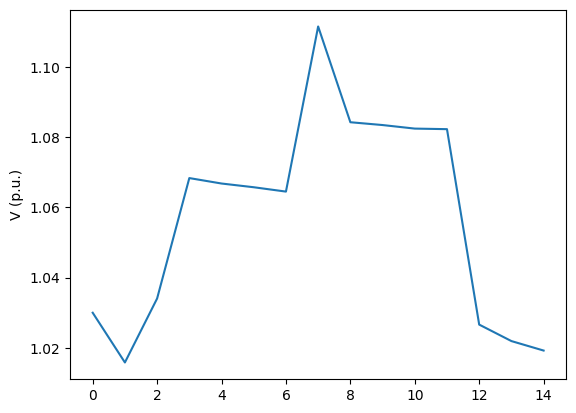

In [4]:
import matplotlib.pyplot as plt
import numpy as np
    
    
# X axis parameter:
xaxis = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11, 12, 13, 14])

# Y axis parameter:
yaxis = net_cigre.res_bus['vm_pu']

# Labels
plt.ylabel('V (p.u.)')

plt.plot(xaxis, yaxis)
plt.show()

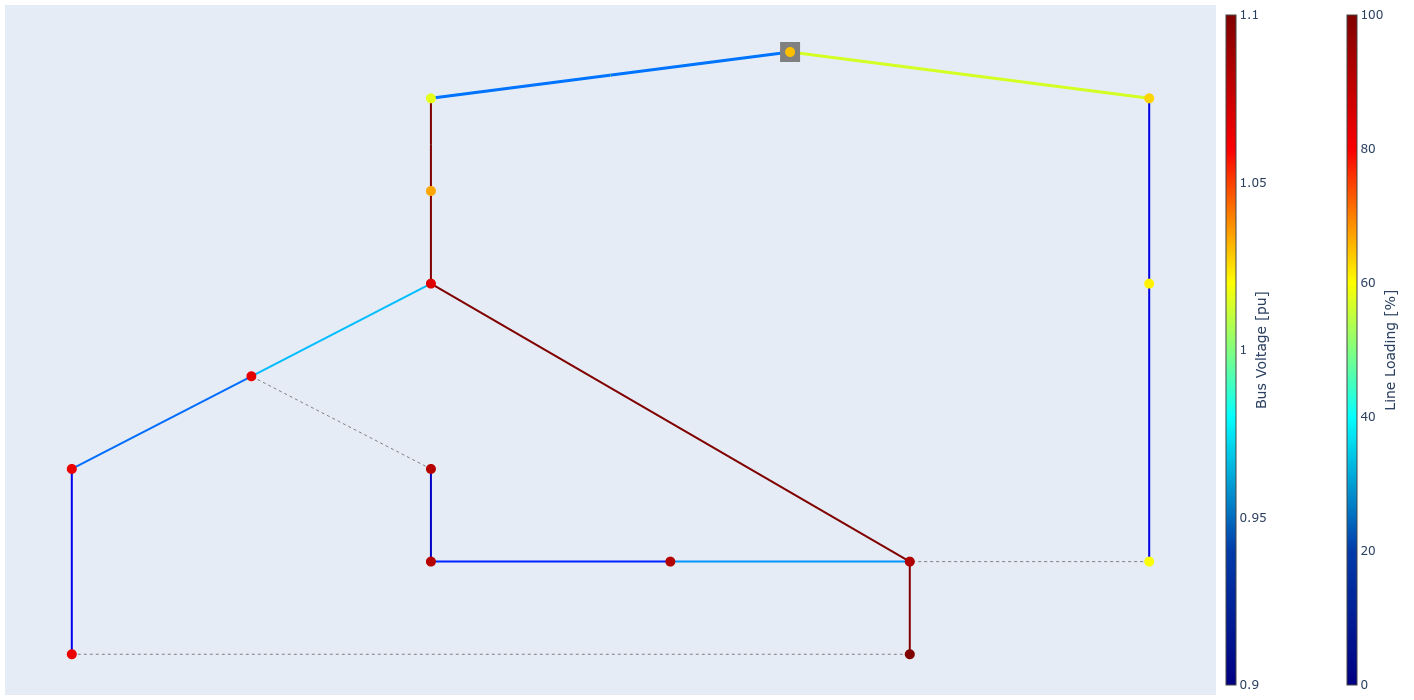

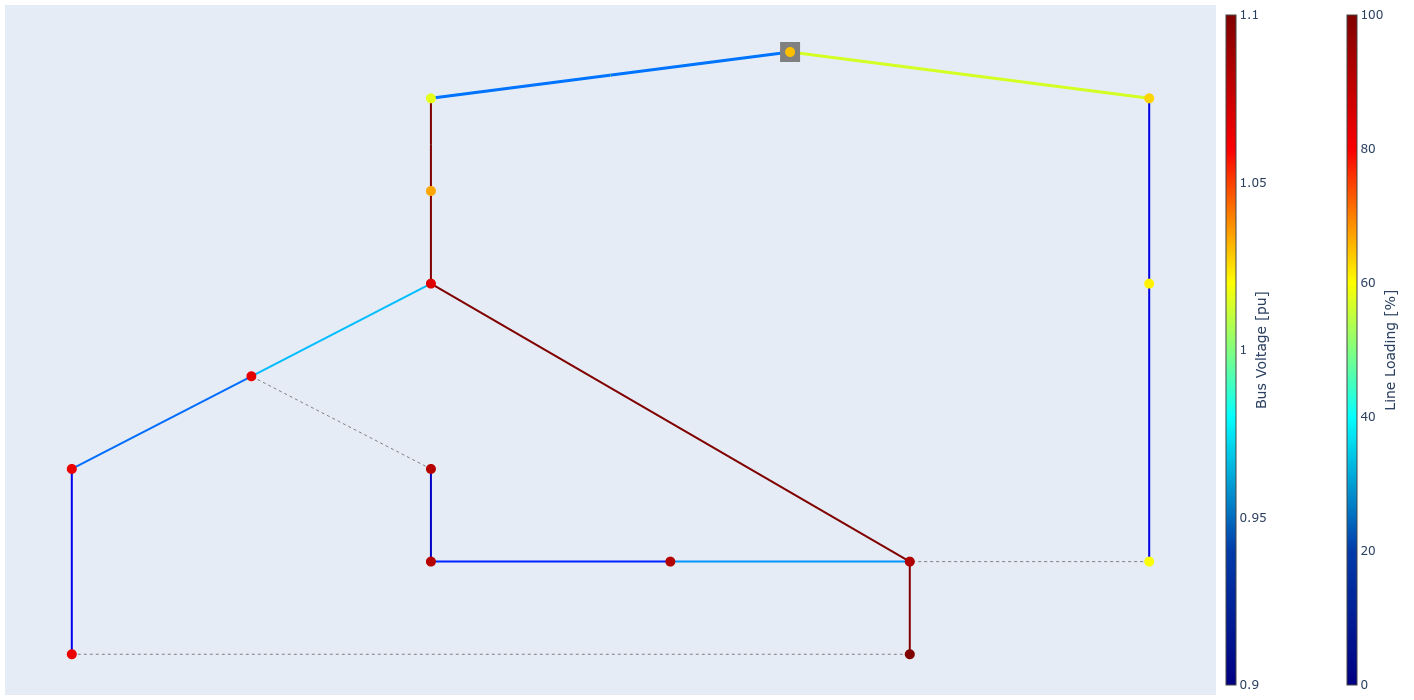

In [5]:
from pandapower.plotting.plotly import pf_res_plotly
pf_res_plotly(net_cigre)

## Optimisation mono-objective with Differential Evolution

Dans cette partie, il est developpé le problème d'optimisation avec un nombre fixé de selfs (s) afin de pouvoir vérifier si l'optimisation fonctionne à la main. Le problème est définit de la manière suivante :

##### Variables : 

$(q,x) \in \mathbb{R}^N \times \{0,1\}^N$

$q = (q_i)_{1 \leq i \leq N}$, $q_i$ [MVAr] : puissance reactive de la self au noeud i, active si $x_i = 1$

$x = (x_i)_{1 \leq i \leq N}$, $x_i$ [-] : variable binaire qui indique si le noeud i a un self installé

##### Paramètres :

N [-] : quantité de noeuds du réseau

s [-] : quantité de selfs à installer

$V_n$ [kV] : tension nominal du réseau (20 kV pour un réseau HTA)

##### Formulation du problème

La formulation du problème est similaire de la formulation pour la résolution avec l'algorithme deterministe SLSQP et l'algorithme génétique. Nous l'avons reformulé parce que l'utilisation d'un problème mixe dans ce cas permet que l'algorithme traite la constrainte d'égalité pour les selfs. Le problème d'optimisation est décrit ci-dessous :


$$
\begin{aligned}
\min_{q,x} \quad & \sum_{i=1}^{N}{q_{i}}  \quad & \textrm{s.t.} \quad & V_{i} \leq V_{max}\\
\quad & \quad & \quad & V_{i} \geq V_{min}    \\
\quad & \quad & \quad & q_{i} \geq 0,2    \\
\quad & \quad & \quad & \sum_{i=1}^{N}{x_{i}} = s    \\
\end{aligned}
$$

### Differential Evolution Algorithm - Example using s=2 selfs

In [6]:
def shigher(x,s):
    aux = np.array([0*i for i in range(len(x))],dtype=np.float64)
    x = x.copy()
    j = 0
    while j<s:
        idx = x.argmax()
        aux[idx] = x[idx]
        x[idx] = 0
        j+=1
    return aux

In [ ]:
# Function reformulation including penalties outside bounds
def fct_model_reseau_penalty(variables):
    
    '''
    Inputs:
        variables : array containing all the initial selfs reactive powers
        
    Outputs:
        cost_function : Objective function value with sum of the penalties
    '''
    
    ##Variables du modèle :
    q_self = variables # q_selfi[MVAr]: puissance reactive installée comme self à chaque noeud i

    q_self = shigher(q_self,s)
    cost_function = sum(q_self)

    N = len(q_self) #N[-]: nb de noeuds du réseau (exclut le noeud source)

    ##Éliminant des selfs inclus par la dernière itération de l'algo
    q_active_cons = [0]*s
    i=0
    for qi in q_self:
        if qi>1e-9 and i<len(q_active_cons):
            q_active_cons[i]=(qi)
            i+=1
    au = np.array(q_active_cons)
    length_au = len(au)
    power_const = -au + np.array([0.2]*length_au)

    penalty_cost = 0

    # Include penalty for reactive power inferior to 0.2
    if power_const.max() > 0:
        penalty_cost += 3000

    cost_function += penalty_cost

    i=len(net_cigre.shunt)-1
    if len(net_cigre.shunt) > 0:
        while i>=0:
            net_cigre.shunt.drop(i, inplace=True)
            i-=1

    ##Creer des shunts
    for index in range(N):
        if q_self[index] != 0:
            pp.create_shunt(net=net_cigre,bus = index+1,q_mvar = q_self[index],p_mw = 0) #On utilise index +1 pour éviter le noeud source (bus 0)

    ##Calcul avec pandapower des tension dans les noeuds (try/except to avoid breaking into points that does not make pandapower's powerflow not converge
    try:
        pp.runpp(net_cigre)
    except:
        None
    V_noeud_aux = (net_cigre.res_bus['vm_pu'].values.tolist())
    V_noeud = [1*i for i in V_noeud_aux[1::]] #On prend toutes les tensions au réseau sauf la tension au noeud source (bus 0)
    tension_out = np.array(V_noeud)
    tension_cost = 0
    max_v = tension_out.max()
    min_v = tension_out.min()
    if tension_out.max() > 0.95:
        tension_cost += 500*(max_v-0.95)
    if tension_out.min() < 0.05:
        tension_cost += 500*(min_v-0.95)
    cost_function += tension_cost
    return cost_function

In [30]:
#Optimisations mono-objectif avec DE
import numpy as np
import math
#Optimisations mono-objectif avec Differential Evolution
import scipy.optimize
from scipy.optimize import NonlinearConstraint, minimize, Bounds
from scipy.optimize import differential_evolution as de

#Paramètres du modèle :

s = 1 # s[-]: nb de selfs à installer
Vn = 20 # Vn[kV]: tension nominal du réseau
N = 14 # N[-]: nb de noeuds du réseau

# Definisions les boundaries de la variables d'optimisation (qi peut être entre 0 et inf, si elle est active sa valeur minimale est 200 kVAr)

bounds = Bounds([0*i for i in range(N)], [5]*N)

global s
s=2
res = de(fct_model_reseau_penalty,bounds = bounds, strategy='rand2bin', maxiter=35, popsize=200, tol=1e-6, mutation=(0.5, 1), recombination=0.8, seed=None, callback=None, disp=True, polish=False, atol=0, updating='immediate', workers=1, x0=[0]*(N))

differential_evolution step 1: f(x)= 35.6789
differential_evolution step 2: f(x)= 35.6223
differential_evolution step 3: f(x)= 35.5567
differential_evolution step 4: f(x)= 35.5567
differential_evolution step 5: f(x)= 35.5567
differential_evolution step 6: f(x)= 35.4579
differential_evolution step 7: f(x)= 35.4579
differential_evolution step 8: f(x)= 35.4579
differential_evolution step 9: f(x)= 35.4232
differential_evolution step 10: f(x)= 35.4232
differential_evolution step 11: f(x)= 35.4232
differential_evolution step 12: f(x)= 35.4232
differential_evolution step 13: f(x)= 35.4232
differential_evolution step 14: f(x)= 35.4232
differential_evolution step 15: f(x)= 35.4232
differential_evolution step 16: f(x)= 35.4232
differential_evolution step 17: f(x)= 35.4232
differential_evolution step 18: f(x)= 35.4232
differential_evolution step 19: f(x)= 35.4232
differential_evolution step 20: f(x)= 35.4232
differential_evolution step 21: f(x)= 35.411
differential_evolution step 22: f(x)= 35.411

In [31]:
print(res)

 message: Maximum number of iterations has been exceeded.
 success: False
     fun: 35.324912328881496
       x: [ 5.288e-01  3.392e+00 ...  7.534e-01  4.023e+00]
     nit: 35
    nfev: 100800


In [32]:
# Resulting array with placement of optimal selfs
res.x
shigher(res.x,s)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 4.09668751, 0.        , 0.        , 0.        ,
       0.        , 4.99437529, 0.        , 0.        ])

In [41]:
# As the the network may contain the selfs added from the last iteration (which are not necessarily the optimal ones)
# we must remove all the added shunts
i=len(net_cigre.shunt)-1
if len(net_cigre.shunt) > 0:
    while i>=0:
        net_cigre.shunt.drop(i, inplace=True)
        i-=1

In [42]:
# After the network is back to its original state, we finally add the selfs given by the DE optimisation
res_array  = shigher(res.x,s)
for index in range(N):
    if res_array[index] != 0:
        pp.create_shunt(net=net_cigre,bus = index+1,q_mvar = res_array[index],p_mw = 0) #On utilise index +1 pour éviter le noeud source (bus 0)

##Calcul avec pandapower des tension dans les noeuds

pp.runpp(net_cigre)

In [43]:
net_cigre.shunt

bus  name    q_mvar  p_mw  vn_kv  step  max_step  in_service
0    7  None  4.096688   0.0   20.0     1         1        True
1   12  None  4.994375   0.0   20.0     1         1        True

In [44]:
net_cigre.res_bus

vm_pu  va_degree       p_mw     q_mvar
0   1.030000   0.000000 -21.740584 -14.784423
1   0.990294  -1.623889  14.839000  -0.362864
2   0.981297   2.724760   0.000000   0.000000
3   0.978281   9.656580   0.481700   0.208882
4   0.976578   9.567440   0.411650   0.108182
5   0.975411   9.506069   0.697500   0.182329
6   0.974047   9.433809   0.518050   0.137354
7   1.002404  15.016971 -14.923500   4.163817
8   0.985068  11.923512   0.556850   0.147078
9   0.984181  11.890680   0.543750   0.355578
10  0.983061  11.836164   0.503300   0.161264
11  0.982885  11.826694   0.319800   0.082656
12  1.002468  -4.137791  15.010000   4.712396
13  0.997659  -4.188706   0.034000   0.021071
14  0.994892  -4.218248   0.540050   0.257713

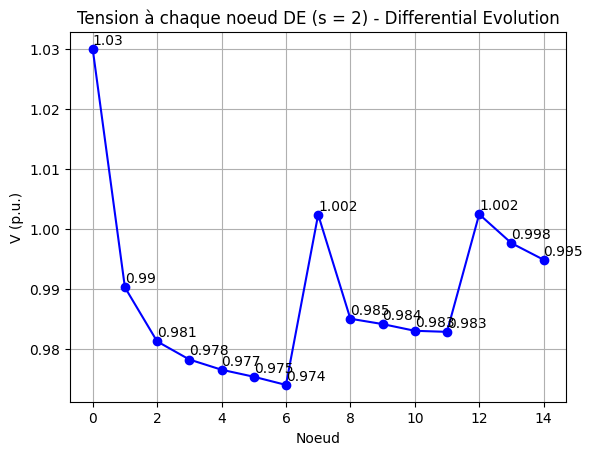

In [45]:
#Plotting the voltage with respect to the bus

import matplotlib.pyplot as plt
import numpy as np
    
# X axis parameter:
xaxis = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11, 12, 13, 14])

# Y axis parameter:
yaxis = net_cigre.res_bus['vm_pu']

# Labels
plt.ylabel('V (p.u.)')
plt.xlabel('Noeud')

for i in range(len(yaxis)):
    plt.annotate(str(round(yaxis[i], 3)), xy=(xaxis[i], yaxis[i]+0.0008))

plt.grid()
plt.title('Tension à chaque noeud DE (s = 2) - Differential Evolution')
plt.plot(xaxis, yaxis, '-bo')
plt.show()

### Plot du réseau avec les selfs ajoutés

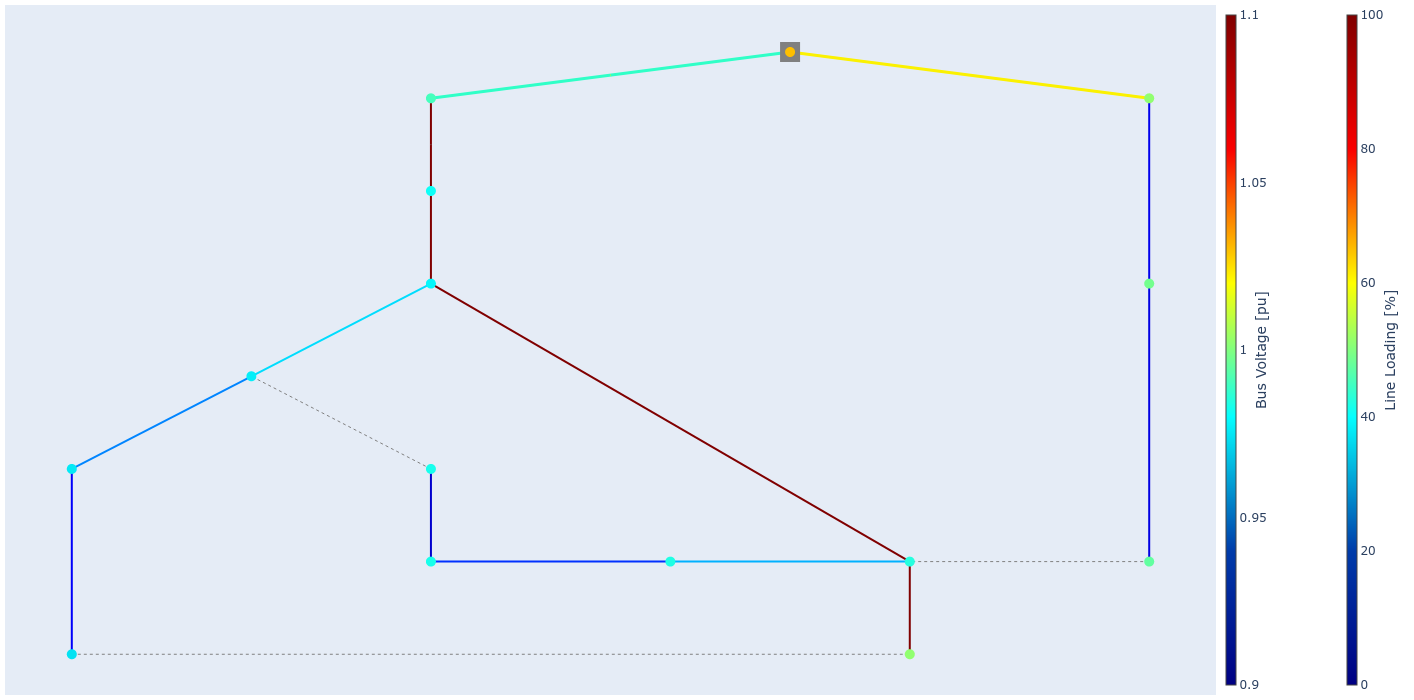

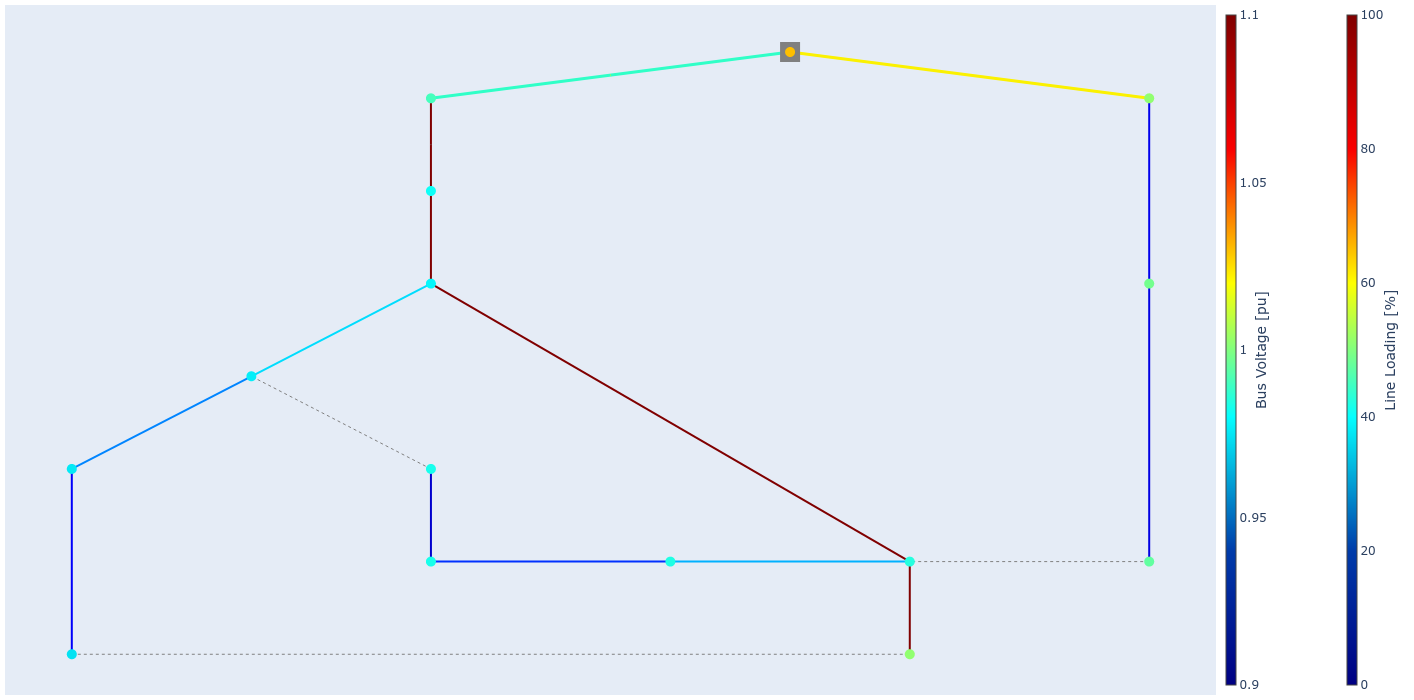

In [40]:
pf_res_plotly(net_cigre)